<a href="https://colab.research.google.com/github/varshith264/Digitalising-an-offline-Chess-Board-/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.applications.imagenet_utils import decode_predictions
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix



In [ ]:
folder = '/content/drive/MyDrive/splitted_data'
image_size = (224, 224)
batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=5,
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        rescale=1./255,
        horizontal_flip=True,
        fill_mode='nearest')


In [ ]:
train_gen = datagen.flow_from_directory(
    folder + '/train',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=True  
)

test_gen = test_datagen.flow_from_directory(
    folder + '/test',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=False 
)

Found 1597 images belonging to 13 classes.
Found 810 images belonging to 13 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x)  # flatten from convolution tensor output  
x = Dense(500, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(500, activation='relu')(x)
predictions = Dense(13, activation='softmax')(x) # should match # of classes predicted



58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
epochs = 10

history = model.fit(
    train_gen, 
    epochs=epochs,
    verbose = 1,
    validation_data=test_gen
    )
model.save_weights('model_VGG16.h5')

Epoch 1/10
50/50 [==============================] - 658s 13s/step - loss: 3.7139 - categorical_accuracy: 0.1937 - val_loss: 1.4479 - val_categorical_accuracy: 0.4704
Epoch 2/10
50/50 [==============================] - 22s 444ms/step - loss: 1.1079 - categorical_accuracy: 0.6255 - val_loss: 0.9461 - val_categorical_accuracy: 0.6679
Epoch 3/10
50/50 [==============================] - 22s 445ms/step - loss: 0.6010 - categorical_accuracy: 0.8008 - val_loss: 0.7756 - val_categorical_accuracy: 0.7284
Epoch 4/10
50/50 [==============================] - 22s 449ms/step - loss: 0.3918 - categorical_accuracy: 0.8759 - val_loss: 0.6456 - val_categorical_accuracy: 0.7716
Epoch 5/10
50/50 [==============================] - 22s 447ms/step - loss: 0.2761 - categorical_accuracy: 0.9235 - val_loss: 0.5186 - val_categorical_accuracy: 0.8247
Epoch 6/10
50/50 [==============================] - 22s 449ms/step - loss: 0.1941 - categorical_accuracy: 0.9410 - val_loss: 0.5265 - val_categorical_accuracy: 0.8358

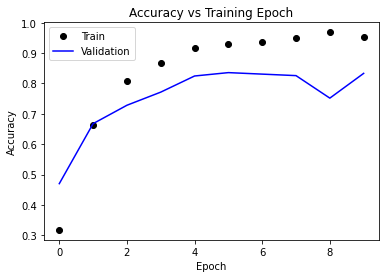

In [ ]:
plt.plot(history.history['categorical_accuracy'], 'ko')
plt.plot(history.history['val_categorical_accuracy'], 'b')

plt.title('Accuracy vs Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation']);



In [ ]:
test_gen.reset()
Y_pred = model.predict_generator(test_gen)
classes = test_gen.classes[test_gen.index_array]
y_pred = np.argmax(Y_pred, axis= -1)
# print(sum(y_pred==classes)/810)

target_names = ['BB', 'BK', 'BN', 'BP', 'BQ', 'BR', 'Empty', 'WB', 'WK', 'WN', 'WP', 'WQ', 'WR']

print(classification_report(test_gen.classes[test_gen.index_array], y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

          BB       0.96      0.75      0.84        67
          BK       0.73      0.77      0.75        35
          BN       0.74      0.83      0.78        58
          BP       0.97      0.92      0.94        65
          BQ       0.68      0.95      0.79        62
          BR       0.84      0.69      0.75        67
       Empty       0.97      0.97      0.97        71
          WB       0.93      0.71      0.80        72
          WK       0.78      0.86      0.82        37
          WN       0.74      0.80      0.77        69
          WP       0.89      0.87      0.88        67
          WQ       0.80      0.88      0.84        67
          WR       0.85      0.84      0.84        73

    accuracy                           0.83       810
   macro avg       0.84      0.83      0.83       810
weighted avg       0.85      0.83      0.83       810



In [ ]:
base_model_two = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model_two.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model_two.output
x = Flatten()(x)  # flatten from convolution tensor output  
x = Dense(500, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(500, activation='relu')(x)
predictions = Dense(13, activation='softmax')(x) # should match # of classes predicted



80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
# this is the model we will train
model_two = Model(inputs=base_model_two.input, outputs=predictions)
model_two.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_two.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
epochs = 10

history = model_two.fit(
    train_gen, 
    epochs=epochs,
    verbose = 1,
    validation_data=test_gen
    )
model.save_weights('model_VGG19.h5')

Epoch 1/10
50/50 [==============================] - 25s 478ms/step - loss: 4.0088 - accuracy: 0.1495 - val_loss: 1.7959 - val_accuracy: 0.4321
Epoch 2/10
50/50 [==============================] - 24s 473ms/step - loss: 1.3044 - accuracy: 0.5721 - val_loss: 1.0254 - val_accuracy: 0.6556
Epoch 3/10
50/50 [==============================] - 24s 475ms/step - loss: 0.7652 - accuracy: 0.7206 - val_loss: 0.8286 - val_accuracy: 0.7111
Epoch 4/10
50/50 [==============================] - 24s 471ms/step - loss: 0.5247 - accuracy: 0.8357 - val_loss: 0.7227 - val_accuracy: 0.7272
Epoch 5/10
50/50 [==============================] - 24s 473ms/step - loss: 0.4647 - accuracy: 0.8400 - val_loss: 0.6969 - val_accuracy: 0.7457
Epoch 6/10
50/50 [==============================] - 24s 471ms/step - loss: 0.3133 - accuracy: 0.8914 - val_loss: 0.6869 - val_accuracy: 0.7778
Epoch 7/10
50/50 [==============================] - 24s 471ms/step - loss: 0.2724 - accuracy: 0.9036 - val_loss: 0.6573 - val_accuracy: 0.7864

In [ ]:
test_gen.reset()
Y_pred = model_two.predict_generator(test_gen)
classes = test_gen.classes[test_gen.index_array]
y_pred = np.argmax(Y_pred, axis= -1)


print(classification_report(test_gen.classes[test_gen.index_array], y_pred, target_names=target_names))



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

          BB       0.74      0.76      0.75        67
          BK       0.68      0.91      0.78        35
          BN       0.60      0.86      0.70        58
          BP       0.86      0.94      0.90        65
          BQ       0.90      0.71      0.79        62
          BR       0.72      0.63      0.67        67
       Empty       1.00      0.97      0.99        71
          WB       1.00      0.49      0.65        72
          WK       0.92      0.32      0.48        37
          WN       0.73      0.59      0.66        69
          WP       0.78      0.91      0.84        67
          WQ       0.66      0.93      0.77        67
          WR       0.75      0.89      0.81        73

    accuracy                           0.77       810
   macro avg       0.80      0.76      0.75       810
weighted avg       0.80      0.77      0.76       810



In [ ]:
new_data = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/cropped_images/',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=False 
)

Found 64 images belonging to 1 classes.


In [ ]:
#for predicting peices from cropped images

new_data.reset()
Y_pred = model.predict_generator(new_data)
classes = new_data.classes[new_data.index_array]
y_pred = np.argmax(Y_pred, axis= -1)

In [ ]:
model3 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in model3.layers:
    layer.trainable = False    

# Establish new fully connected block
x = model3.output
x = Flatten()(x)  # flatten from convolution tensor output  
x = Dense(500, activation='sigmoid')(x) # number of layers and units are hyperparameters, as usual
x = Dense(500, activation='sigmoid')(x)
predictions = Dense(13, activation='softmax')(x) # should match # of classes predicted



58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
# this is the model we will train
model3 = Model(inputs=model3.input, outputs=predictions)
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model3.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
epochs = 10

history = model3.fit(
    train_gen, 
    epochs=epochs,
    verbose = 1,
    validation_data=test_gen
    )
model3.save_weights('model3_s.h5')

Epoch 1/10
50/50 [==============================] - 670s 13s/step - loss: 2.6856 - categorical_accuracy: 0.1114 - val_loss: 2.1804 - val_categorical_accuracy: 0.2321
Epoch 2/10
50/50 [==============================] - 22s 438ms/step - loss: 2.0067 - categorical_accuracy: 0.3307 - val_loss: 1.6042 - val_categorical_accuracy: 0.4321
Epoch 3/10
50/50 [==============================] - 22s 440ms/step - loss: 1.4177 - categorical_accuracy: 0.5129 - val_loss: 1.2194 - val_categorical_accuracy: 0.6074
Epoch 4/10
50/50 [==============================] - 22s 441ms/step - loss: 1.0282 - categorical_accuracy: 0.7076 - val_loss: 0.9920 - val_categorical_accuracy: 0.6963
Epoch 5/10
50/50 [==============================] - 22s 444ms/step - loss: 0.7787 - categorical_accuracy: 0.7615 - val_loss: 0.7637 - val_categorical_accuracy: 0.7556
Epoch 6/10
50/50 [==============================] - 22s 441ms/step - loss: 0.5349 - categorical_accuracy: 0.8777 - val_loss: 0.6888 - val_categorical_accuracy: 0.7889

In [ ]:
test_gen.reset()
Y_pred = model3.predict_generator(test_gen)
classes = test_gen.classes[test_gen.index_array]
y_pred = np.argmax(Y_pred, axis= -1)


print(classification_report(test_gen.classes[test_gen.index_array], y_pred, target_names=target_names))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

          BB       0.98      0.67      0.80        67
          BK       0.87      0.77      0.82        35
          BN       0.80      0.81      0.80        58
          BP       0.95      0.91      0.93        65
          BQ       0.82      0.87      0.84        62
          BR       0.69      0.91      0.78        67
       Empty       1.00      0.97      0.99        71
          WB       0.72      0.75      0.73        72
          WK       0.92      0.32      0.48        37
          WN       0.79      0.75      0.77        69
          WP       0.75      0.93      0.83        67
          WQ       0.67      0.96      0.79        67
          WR       0.93      0.71      0.81        73

    accuracy                           0.81       810
   macro avg       0.84      0.80      0.80       810
weighted avg       0.83      0.81      0.81       810



In [ ]:
model4 = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in model4.layers:
    layer.trainable = False    

# Establish new fully connected block
x = model4.output
x = Flatten()(x)  # flatten from convolution tensor output  
x = Dense(500, activation='sigmoid')(x) # number of layers and units are hyperparameters, as usual
x = Dense(500, activation='sigmoid')(x)
predictions = Dense(13, activation='softmax')(x) # should match # of classes predicted



In [ ]:
# this is the model we will train
model4 = Model(inputs=model4.input, outputs=predictions)
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model4.summary()

In [ ]:
epochs = 10

history = model4.fit(
    train_gen, 
    epochs=epochs,
    verbose = 1,
    validation_data=test_gen
    )
model4.save_weights('model3_s.h5')